In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys
import importlib  

import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from sklearn.utils import resample, shuffle

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from localfinlab.clustering import *

import localfinlab as lfl
from localfinlab.utils import flatten, postfix_keys_to_dict, get_current_time_hash, get_random_hash


In [3]:
import sys
sys.path.append("/home/aaron/notebooks/test-strategy/thesis/sarmento-original-thesis/classes")

dp_foobar = importlib.import_module("class_DataProcessor")

series_analyser = lfl.pairs_trading_backtester.series_analyser.SeriesAnalyser()
data_processor = dp_foobar.DataProcessor()

# load etf metadata
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(path='../sarmento-original-thesis/data/commodity_ETFs_long_updated.xlsx')

# intraday
df_prices = pd.read_pickle('../sarmento-original-thesis/data/pickle/commodity_ETFs_from_2014_complete.pickle')

SPLIT_IDX = 2

splits = [ 
    [('01-01-2012', '31-12-2014'), ('01-01-2015', '31-12-2015'), '2014-01-01'],
    [('01-01-2013', '31-12-2015'), ('01-01-2016', '31-12-2016'), '2015-01-01'],
    [('01-01-2014', '31-12-2016'), ('01-01-2017', '31-12-2017'), '2016-01-01'] 
]

# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices, splits[SPLIT_IDX][0], splits[SPLIT_IDX][1], remove_nan=True)

df_train_returns = data_processor.get_return_series(df_prices_train)#.asfreq('B').dropna()
df_test_returns = data_processor.get_return_series(df_prices_test)#.asfreq('B').dropna()


Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

# Convert string categorical set describing asset sectors/segments to integer.

enc = OrdinalEncoder()

sector_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Sector']

enc.fit(sector_data_df.astype(str).values.reshape(-1, 1))

sector_ground_truth = enc.transform(sector_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)


segment_data_df = etfs_unique[etfs_unique['Ticker'].isin(df_train_returns.columns)]['Segment']

enc.fit(segment_data_df.astype(str).values.reshape(-1, 1))

segment_ground_truth = enc.transform(segment_data_df.astype(str).values.reshape(-1, 1)).reshape(-1)

In [13]:
assigned_labels_pca = []
assigned_labels_ae = []

In [16]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA

kmeans_algo_pca_template = {'init':['k-means++'], 'n_clusters': [46], 'n_init': [20]}
kmeans_algo_ae_template = {'init':['k-means++'], 'n_clusters': [30], 'n_init': [20]}


# GET VALUES FOR PCA

scaler = StandardScaler()

scaled_data = scaler.fit_transform(df_train_returns)

pca_instance = PCA(n_components=25)

reduced_data = pca_instance.fit_transform(scaled_data)

feature_df = pd.DataFrame(pca_instance.components_, columns=df_train_returns.columns).T

km_clustered_series_all, km_clustered_series, km_counts, assigned_labels = series_analyser.apply_clustering_algo('kmeans', feature_df,
                                                                                                        df_train_returns.columns, 
                                                                                                        permute_params(kmeans_algo_pca_template)[0])

assigned_labels_pca.append(assigned_labels)

# GET VALUES FOR AUTOENCODER

for model_identifier in glob.glob('../experiment 3/ae_exhaust/covariance_matrix/embedding_sets/' + str(SPLIT_IDX) + '/*.csv'):

    pre_train_clusterable_feature_df = pd.read_csv(model_identifier).iloc[:, 1:]

    km_clustered_series_all, km_clustered_series, km_counts, _assigned_labels = series_analyser.apply_clustering_algo('kmeans', pre_train_clusterable_feature_df,
                                                                                                            df_train_returns.columns, 
                                                                                                            permute_params(kmeans_algo_ae_template)[0])

    assigned_labels_ae.append(_assigned_labels) 


{'init': 'k-means++', 'n_clusters': 46, 'n_init': 20}
Clusters discovered: 46
Pairs to evaluate: 254
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 356
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 314
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 367
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 357
{'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Clusters discovered: 30
Pairs to evaluate: 430


In [5]:
def get_series_mask(working_series):

    one_sized_clusters_ground = working_series.value_counts()[working_series.value_counts() < 3].index

    return (working_series.isin(one_sized_clusters_ground)).astype(int)


In [17]:
from pySankeyBeta.pysankey.sankey import sankey
pd.options.display.max_rows = 8

segment_series = pd.Series(segment_ground_truth.reshape(-1).astype(int))
series_assigned_labels = pd.Series(assigned_labels)
series__assigned_labels = pd.Series(_assigned_labels)

sankeyd_ground_to_pca_df = pd.concat([pd.Series(enc.inverse_transform(segment_ground_truth.reshape(-1, 1)).reshape(-1)), pd.Series(assigned_labels)], axis=1)
sankeyd_ground_to_pca_df.columns = ['Ground', 'PCA']
sankeyd_ground_to_pca_df = sankeyd_ground_to_pca_df[~(get_series_mask(segment_series) | get_series_mask(series_assigned_labels)).astype(bool)]


sankeyd_ground_to_ae_df = pd.concat([pd.Series(enc.inverse_transform(segment_ground_truth.reshape(-1, 1)).reshape(-1)), pd.Series(_assigned_labels)], axis=1)
sankeyd_ground_to_ae_df.columns = ['Ground', 'AE']
sankeyd_ground_to_ae_df = sankeyd_ground_to_ae_df[~(get_series_mask(segment_series) | get_series_mask(series__assigned_labels)).astype(bool)]

sankeyd_pca_to_ae_df = pd.concat([pd.Series(assigned_labels), pd.Series(_assigned_labels)], axis=1)
sankeyd_pca_to_ae_df.columns = ['PCA', 'AE']
sankeyd_pca_to_ae_df = sankeyd_pca_to_ae_df[~(get_series_mask(series_assigned_labels) | get_series_mask(series__assigned_labels)).astype(bool)]


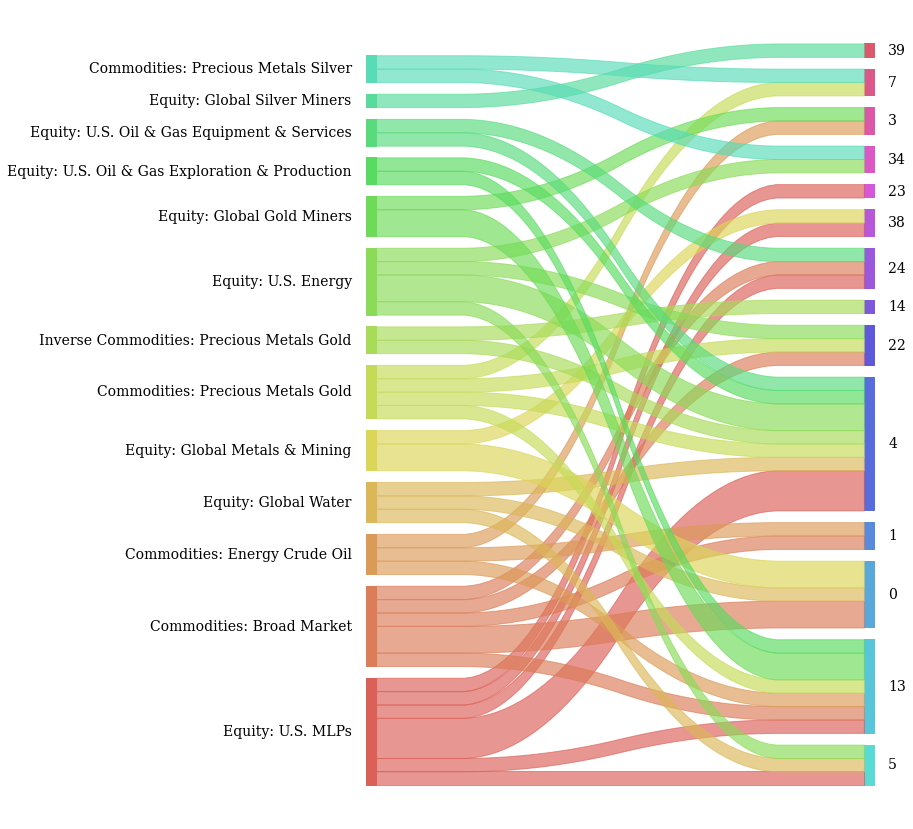

In [18]:

fig, ax = plt.subplots(figsize=(10, 15))

sankey(sankeyd_ground_to_pca_df['Ground'], sankeyd_ground_to_pca_df['PCA'], aspect=20, ax=ax)


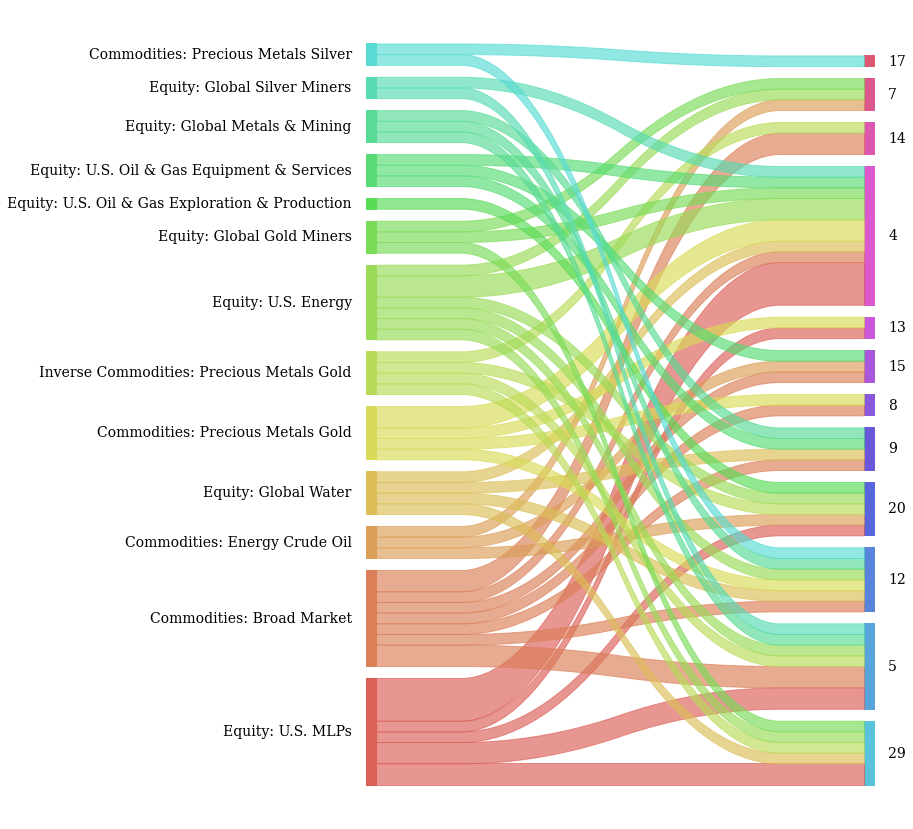

In [19]:

fig, ax = plt.subplots(figsize=(10, 15))

sankey(sankeyd_ground_to_ae_df['Ground'], sankeyd_ground_to_ae_df['AE'], aspect=10, ax=ax)

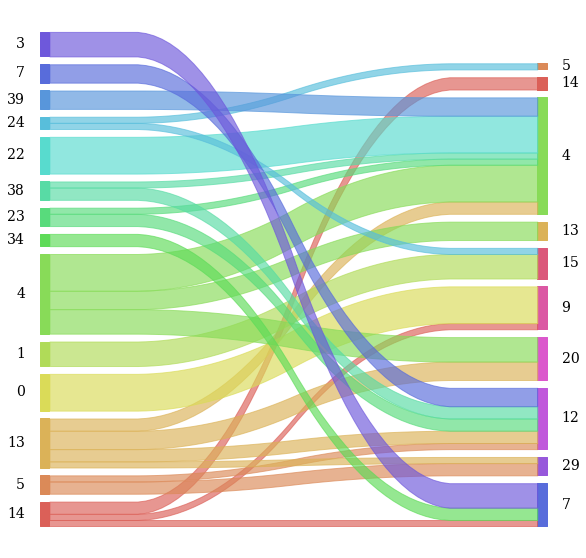

In [20]:

fig, ax = plt.subplots(figsize=(10, 10))

sankey(sankeyd_pca_to_ae_df['PCA'], sankeyd_pca_to_ae_df['AE'], aspect=10, ax=ax)